In [1]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from dotenv import load_dotenv

In [2]:
def convert_to_mel_spectrogram(audio, sr, n_fft, hop_length, n_mels):
    if audio is None:
        return None
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels, fmax=sr / 2)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

In [3]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
hop_length = int(os.getenv('hop_length'))
n_mels = int(os.getenv('n_mels'))
n_fft = int(os.getenv('n_fft'))

In [4]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            target_sample_rate = sr
            path = file.split(os.path.sep)
            filename = f'{path[-1]}'
            wav_files.append((y, filename))
    return wav_files

In [5]:
# 讀取分割後的音訊片段
normal_segments = load_segmented_files('output')
# 打亂 mel_spectrograms_normal 列表
np.random.shuffle(normal_segments)

100%|██████████| 2230/2230 [00:09<00:00, 235.83it/s]


In [6]:
mel_spectrograms_normal = [convert_to_mel_spectrogram(audio[0], sample_rate, n_fft, hop_length, n_mels) for audio in tqdm(normal_segments)]

100%|██████████| 2230/2230 [00:18<00:00, 117.47it/s]


In [7]:
def plot_mel_spectrogram(mel_spectrogram, sr, filename:str = None):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel spectrogram of {filename}')
    plt.savefig(f'{filename}_mel_spectrogram.png')
    plt.show()

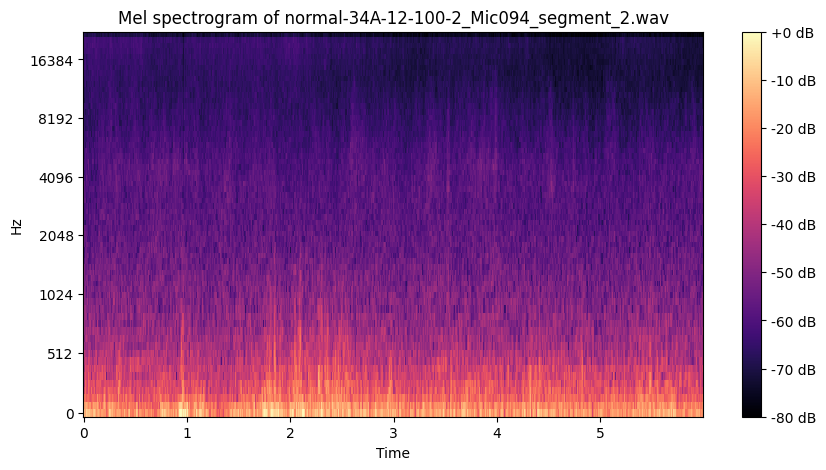

In [8]:
plot_mel_spectrogram(mel_spectrograms_normal[0], sample_rate, f'{normal_segments[0][1]}')

# Spilt Dataset to training and testing

In [9]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms_normal)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (1427, 64, 1034)
驗證集數據形狀: (357, 64, 1034)
測試集數據形狀: (446, 64, 1034)


# 調整數據的形狀

In [10]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (1427, 64, 1034, 1)
驗證集數據形狀: (357, 64, 1034, 1)
測試集數據形狀: (446, 64, 1034, 1)


# 創建 CNN Autoencoder 模型

In [22]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, \
    BatchNormalization
from tensorflow.keras.regularizers import l2


def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[0]
    input_width = input_shape[1]
    
    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Flatten and Dense layers at bottleneck
    x = Flatten()(encoded)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(encoded.shape[1] * encoded.shape[2] * encoded.shape[3], activation='relu')(x)
    x = Reshape((encoded.shape[1], encoded.shape[2], encoded.shape[3]))(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    
    # Ensure the output has the same size as input
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :input_height, :input_width, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [23]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 1034, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 1034, 64)      640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 517, 64)      0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 517, 32)       18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 259, 32)      0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 259, 16)       4624

In [24]:
def plot_model(autoencoder):
    from tensorflow.keras.utils import plot_model
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    
plot_model(autoencoder)

In [28]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
# 設定初始學習率
initial_learning_rate = 0.0001

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)

def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mse_loss + mae_loss


# 編譯模型
autoencoder.compile(optimizer=optimizer, loss=combined_loss)

# 訓練模型

In [30]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)
history = autoencoder.fit(train_data, train_data,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[reduce_lr],
                verbose=2)

Epoch 1/100
90/90 - 6s - loss: 0.0406 - val_loss: 0.0412 - lr: 2.5000e-05 - 6s/epoch - 68ms/step
Epoch 2/100
90/90 - 6s - loss: 0.0404 - val_loss: 0.0406 - lr: 2.5000e-05 - 6s/epoch - 68ms/step
Epoch 3/100
90/90 - 6s - loss: 0.0402 - val_loss: 0.0409 - lr: 2.5000e-05 - 6s/epoch - 68ms/step
Epoch 4/100
90/90 - 6s - loss: 0.0403 - val_loss: 0.0404 - lr: 2.5000e-05 - 6s/epoch - 68ms/step
Epoch 5/100
90/90 - 6s - loss: 0.0402 - val_loss: 0.0426 - lr: 2.5000e-05 - 6s/epoch - 68ms/step
Epoch 6/100
90/90 - 6s - loss: 0.0401 - val_loss: 0.0407 - lr: 2.5000e-05 - 6s/epoch - 71ms/step
Epoch 7/100
90/90 - 6s - loss: 0.0401 - val_loss: 0.0411 - lr: 2.5000e-05 - 6s/epoch - 69ms/step
Epoch 8/100
90/90 - 7s - loss: 0.0402 - val_loss: 0.0408 - lr: 2.5000e-05 - 7s/epoch - 78ms/step
Epoch 9/100
90/90 - 7s - loss: 0.0401 - val_loss: 0.0410 - lr: 2.5000e-05 - 7s/epoch - 77ms/step
Epoch 10/100
90/90 - 7s - loss: 0.0397 - val_loss: 0.0408 - lr: 2.5000e-05 - 7s/epoch - 78ms/step
Epoch 11/100
90/90 - 7s - los

# 評估模型

In [31]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

12/12 [==============================] - 2s 55ms/step - loss: 0.0375
Test loss: 0.03752667084336281


# 繪製訓練過程

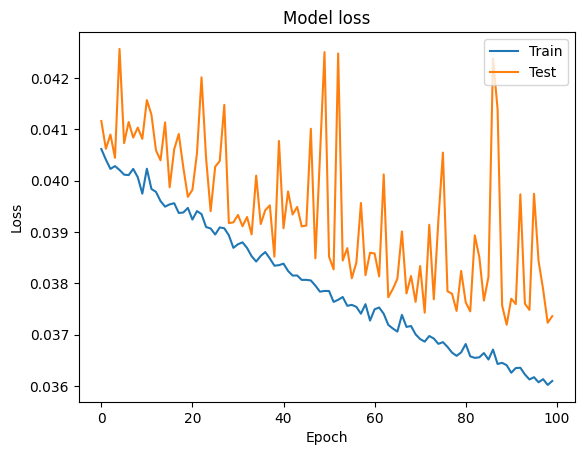

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

# 儲存模型

In [33]:
autoencoder.save('autoencoder.h5')

# 使用測試集數據進行預測

In [36]:
reconstructed_data = autoencoder.predict(test_data)
reconstructed_train_data = autoencoder.predict(train_data)

loss = np.mean(combined_loss(test_data, reconstructed_data))
print("Train loss:", loss)

45/45 [==============================] - 2s 44ms/step
Train loss: 0.032623902


In [ ]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, mse_threshold, output_name='comparison', save_only=False):
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    mse = np.square(input_mel_spectrogram - output_mel_spectrogram).mean()
    # plot mse if mse in red if mse > mse_threshold
    plt.text(0, 0, f'MSE: {mse}', fontsize=12, color='red' if mse > mse_threshold else 'black', backgroundcolor='white')
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_name}.png')
        plt.close()
    else:
        plt.show()

In [ ]:
test_index = 300
plot_comparison(test_data[test_index].reshape(test_data[test_index].shape[0], test_data[test_index].shape[1]),
                reconstructed_data[test_index].reshape(reconstructed_data[test_index].shape[0], reconstructed_data[test_index].shape[1]),
                'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', mse_threshold=mse_train, output_name=f'{normal_segments[len(train_data) + len(val_data) + test_index][1]}')

In [ ]:
for i in tqdm(range(0, len(test_data))):
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_data[i].reshape(reconstructed_data[i].shape[0], reconstructed_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', mse_threshold=mse_train, output_name=f'images/reconstruct/{normal_segments[len(train_data) + len(val_data) + i][1]}', save_only=True)

計算評估指標

In [ ]:
# 計算均方誤差 (MSE)
mse = np.mean((test_data - reconstructed_data) ** 2)
print("Reconstruction MSE:", mse)

# 計算平均絕對誤差 (MAE)
mae = np.mean(np.abs(test_data - reconstructed_data))
print("Reconstruction MAE:", mae)

# 計算均方根誤差 (RMSE)
rmse = np.sqrt(np.mean((test_data - reconstructed_data) ** 2))
print("Reconstruction RMSE:", rmse)

Reconstruct lost